# Install required packages:

In [17]:
!pip install catboost

     |████████████████████████████████| 64.8MB 52kB/s 


In [18]:
!pip install scikit-optimize

     |████████████████████████████████| 81kB 3.2MB/s 


In [65]:
!pip install xgboost

In [0]:
#Importing libraries 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
import seaborn as sns
from sklearn.metrics import classification_report
import datetime as dt
from sklearn import model_selection
from sklearn import preprocessing

# Utility libs
from tqdm import tqdm
import time
import datetime
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt.plots import plot_convergence
import os
import catboost


In [0]:
train=pd.read_csv("/content/Train.csv")
test=pd.read_csv("/content/Test.csv")

In [88]:
train.shape,test.shape

((23856, 18), (15903, 17))

In [89]:
train.dtypes

INCIDENT_ID          object
DATE                 object
X_1                   int64
X_2                   int64
X_3                   int64
X_4                   int64
X_5                   int64
X_6                   int64
X_7                   int64
X_8                   int64
X_9                   int64
X_10                  int64
X_11                  int64
X_12                float64
X_13                  int64
X_14                  int64
X_15                  int64
MULTIPLE_OFFENSE      int64
dtype: object

In [90]:
train.head

<bound method NDFrame.head of       INCIDENT_ID       DATE  X_1  X_2  ...  X_13  X_14  X_15  MULTIPLE_OFFENSE
0       CR_102659  04-JUL-04    0   36  ...    92    29    36                 0
1       CR_189752  18-JUL-17    1   37  ...   103   142    34                 1
2       CR_184637  15-MAR-17    0    3  ...   110    93    34                 1
3       CR_139071  13-FEB-09    0   33  ...    72    29    34                 1
4       CR_109335  13-APR-05    0   33  ...   112    29    43                 1
...           ...        ...  ...  ...  ...   ...   ...   ...               ...
23851    CR_88991  11-JAN-02    1   47  ...    98    29    34                 1
23852    CR_46369  05-FEB-97    0   33  ...   112    29    43                 1
23853   CR_157556  03-APR-12    0   25  ...    10    29    18                 1
23854   CR_103180  25-JAN-04    0   39  ...   112   103    43                 1
23855    CR_22575  08-NOV-94    7   36  ...    92    29    34                 1

[23856 ro

In [91]:
#Columns which have null values in Train
train.isnull().sum()

INCIDENT_ID           0
DATE                  0
X_1                   0
X_2                   0
X_3                   0
X_4                   0
X_5                   0
X_6                   0
X_7                   0
X_8                   0
X_9                   0
X_10                  0
X_11                  0
X_12                182
X_13                  0
X_14                  0
X_15                  0
MULTIPLE_OFFENSE      0
dtype: int64

In [92]:
#Columns which have null values in Test
test.isnull().sum()

INCIDENT_ID      0
DATE             0
X_1              0
X_2              0
X_3              0
X_4              0
X_5              0
X_6              0
X_7              0
X_8              0
X_9              0
X_10             0
X_11             0
X_12           127
X_13             0
X_14             0
X_15             0
dtype: int64

In [93]:
train['MULTIPLE_OFFENSE'].value_counts()
# This is an imbalanced dataset

1    22788
0     1068
Name: MULTIPLE_OFFENSE, dtype: int64

In [94]:
train[['INCIDENT_ID','DATE']].sort_values('DATE')

#The CR_Numbers don't necessarily follow a strict pattern as per date

,INCIDENT_ID,DATE
23407,CR_64567,01-APR-00
5141,CR_67892,01-APR-00
22426,CR_64509,01-APR-00
5260,CR_64677,01-APR-00
6584,CR_70210,01-APR-00
...,...,...
15690,CR_53107,31-OCT-98
1877,CR_51290,31-OCT-98
20209,CR_54167,31-OCT-98
10337,CR_61624,31-OCT-99


In [95]:
#Min-Max range of X_* columns in train
def minMax(x):
    return pd.Series(index=['min','max'],data=[x.min(),x.max()])

train.filter(like='X_', axis=1).apply(minMax)

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
min,0,0,0,0,0,1,0,0,0,1,0,0.0,0,0,0
max,7,52,52,10,5,19,18,99,6,90,332,90.0,116,142,50


In [96]:
#Min-Max range of X_* columns in test
test.filter(like='X_', axis=1).apply(minMax)

,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,X_14,X_15
min,0,0,0,0,0,1,0,0,0,1,0,0.0,0,0,0
max,7,52,52,10,5,19,18,50,6,40,332,40.0,117,142,50


In [0]:
#Lets try to interpret which of the X_* columns can be taken as categorical and which ones as numerical

#Finding the unique values for X_* columns in train
train_unique_values = {
        colname: list(train[colname].value_counts().sort_index().index)
        for colname in [x for x in train.columns if x.startswith('X_')]
    }

In [98]:
#To check unique values in each column
{key:len(value) for key,value in train_unique_values.items()}

{'X_1': 8,
 'X_10': 24,
 'X_11': 133,
 'X_12': 23,
 'X_13': 60,
 'X_14': 62,
 'X_15': 28,
 'X_2': 52,
 'X_3': 52,
 'X_4': 10,
 'X_5': 5,
 'X_6': 19,
 'X_7': 19,
 'X_8': 24,
 'X_9': 7}

In [0]:
#From above we can interpret Catagorical for columns X_1,X_4,X_5,X_6,X_7,X_9 since their range of values as not more than 20

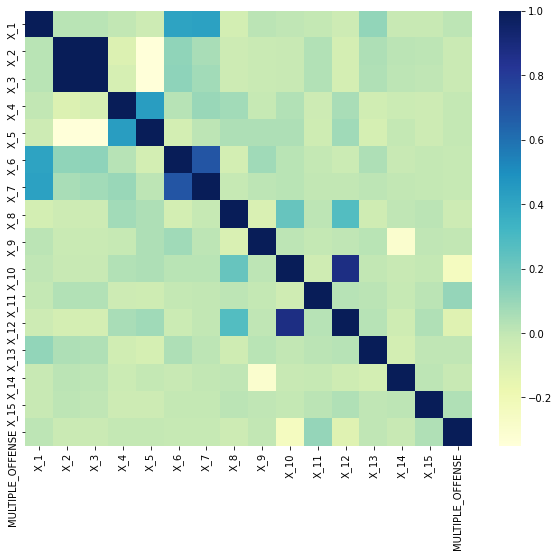

In [100]:
#Correlation of X_* features with MULTIPLE_OFFENSE
corr=train.filter(like='X_', axis=1).join(train['MULTIPLE_OFFENSE']).corr()
sns.heatmap(corr,cmap="YlGnBu")

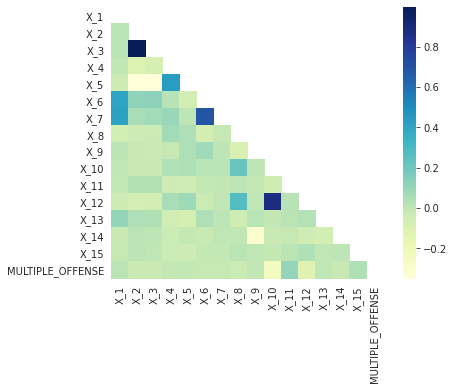

In [101]:
#removing the diagnol elements in heatmap for easier visualization

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(7, 5))
    ax = sns.heatmap(corr, mask=mask, cmap="YlGnBu", square=True)

In [102]:
#Checking correlation of all fields with MULTIPLE_OFFENSE

print (corr['MULTIPLE_OFFENSE'].sort_values(ascending=False)[:5], '\n') #top 5 values
print ('----------------------')
print (corr['MULTIPLE_OFFENSE'].sort_values(ascending=False)[-5:]) #last 5 values

#here we see MULTIPLE_OFFENSE does'nt have a good correlation with any of the X_ columns

MULTIPLE_OFFENSE    1.000000
X_11                0.105088
X_15                0.044916
X_1                 0.014034
X_13                0.006512
Name: MULTIPLE_OFFENSE, dtype: float64 

----------------------
X_3    -0.027218
X_2    -0.027293
X_8    -0.033397
X_12   -0.113061
X_10   -0.242596
Name: MULTIPLE_OFFENSE, dtype: float64


In [103]:
#Checking correlation of all fields with each other

print (corr['X_2'].sort_values(ascending=False)[:3], '\n') #top 3 values
print ('----------------------')
print (corr['X_2'].sort_values(ascending=False)[-3:]) #last 3 values

#Correlated elements: [X2,X3]-0.99,[X_10,X_12]-0.877

X_2    1.000000
X_3    0.996985
X_6    0.119718
Name: X_2, dtype: float64 

----------------------
X_12   -0.067720
X_4    -0.104321
X_5    -0.349190
Name: X_2, dtype: float64


### Visual Analysis:

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


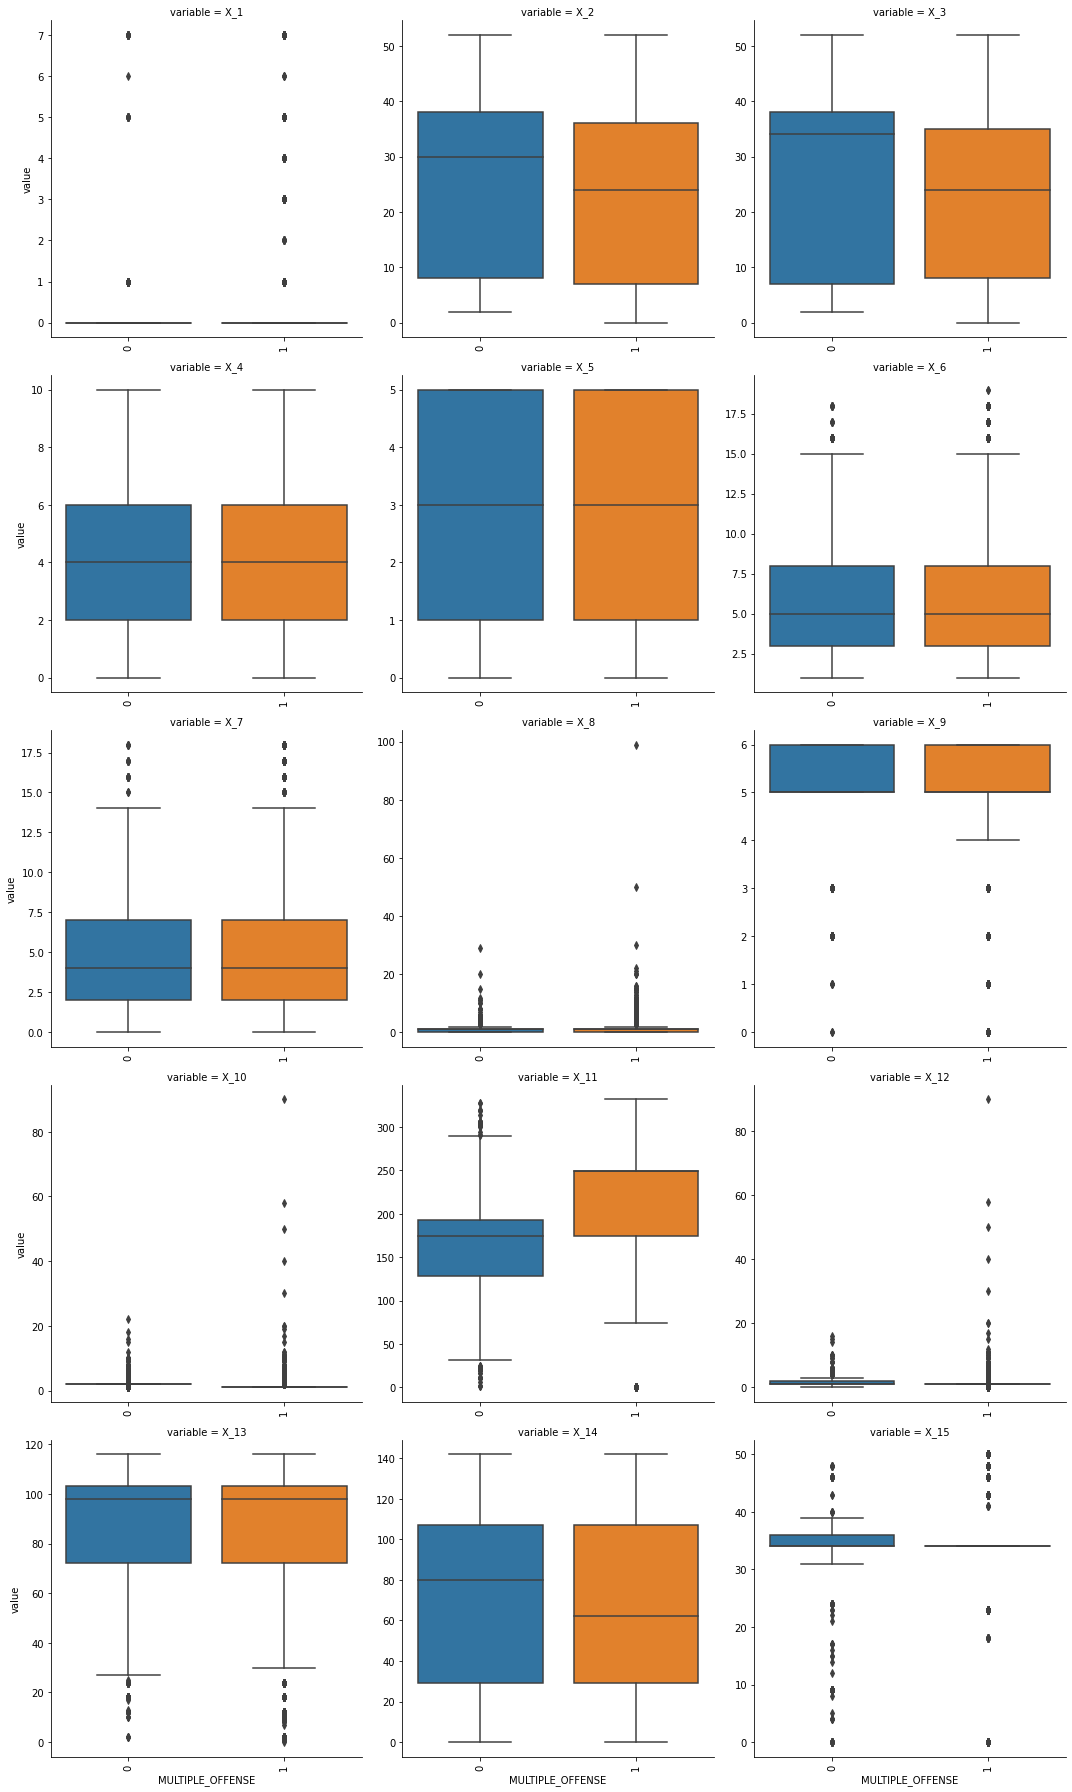

In [104]:
#Lets create a box plot of all X_* features with MULTIPLE_OFFENSE as hue in train
def boxplot(x,y,**kwargs):
            sns.boxplot(x=x,y=y)
            x = plt.xticks(rotation=90)

features =[x for x in train.columns if x.startswith('X_')]
p = pd.melt(train, id_vars='MULTIPLE_OFFENSE', value_vars=features)
g = sns.FacetGrid (p, col='variable', col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(boxplot, 'MULTIPLE_OFFENSE','value')
g

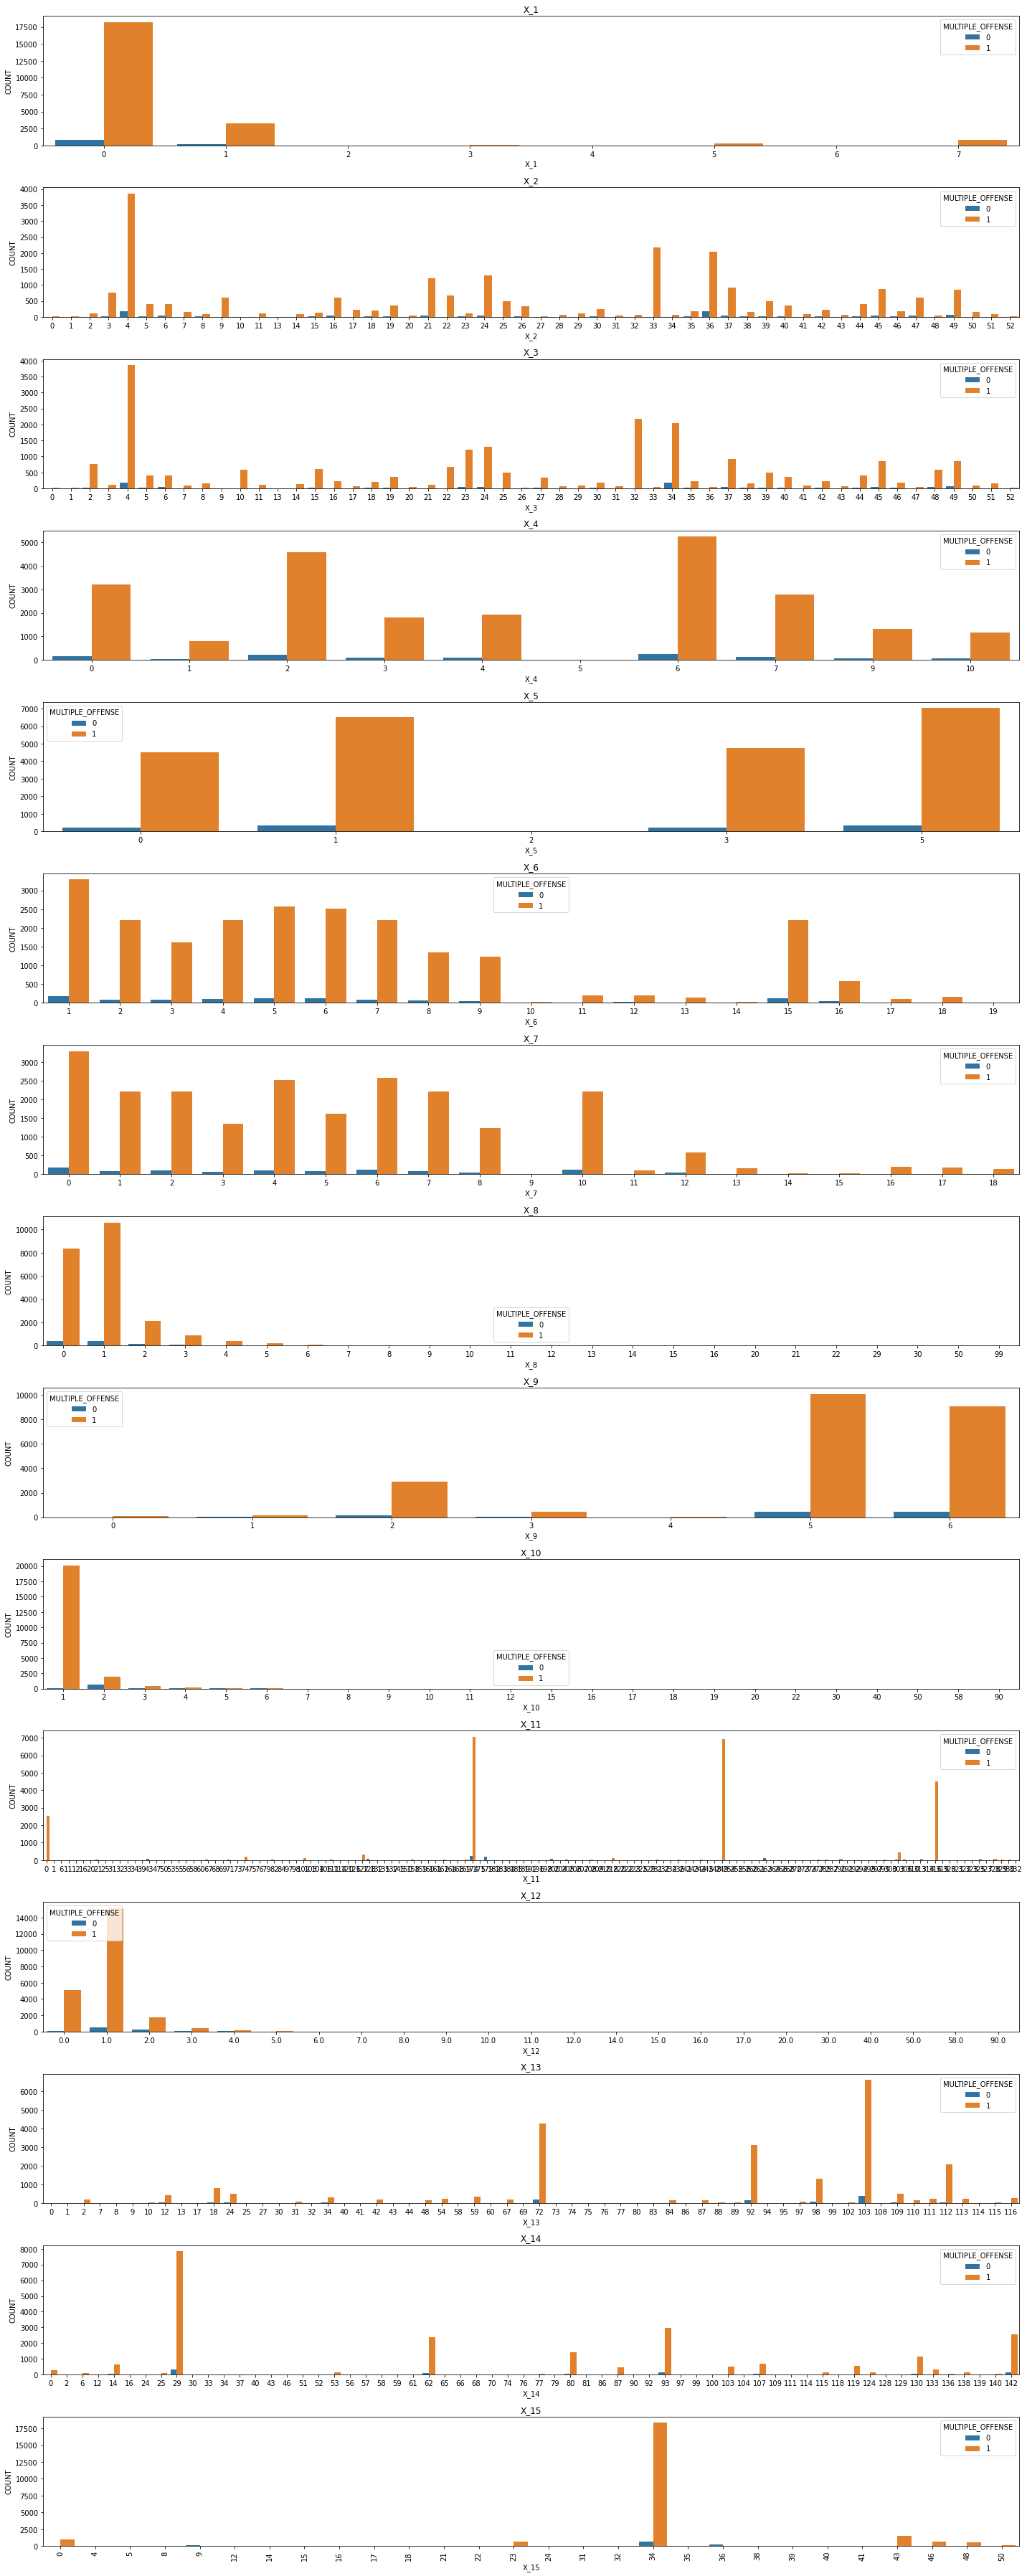

In [105]:
#Lets create a box plot of all X_* features with MULTIPLE_OFFENSE as hue in train
fig, axes =plt.subplots(15,1)
for t,i in enumerate([x for x in train.columns if x.startswith('X_')]):
  sns.barplot(x=i,y='COUNT',hue='MULTIPLE_OFFENSE',data=train.groupby([i])['MULTIPLE_OFFENSE'].value_counts().to_frame().rename(columns={'MULTIPLE_OFFENSE':'COUNT'}).reset_index(),ax=axes[t])
  axes[t].figure.set_size_inches(20, 50)
  axes[t].set_title(i)
  plt.xticks(rotation=90)
  plt.tight_layout()

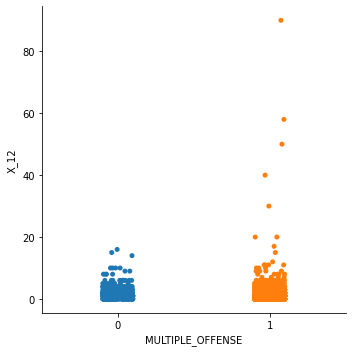

In [41]:
#Univariate Analysis
sns.catplot(x="MULTIPLE_OFFENSE", y="X_12", data=train);

#Here we see anything above X_12=20 is Hacked(1)

## Model Building Phase:

1. For a more modular approach , I have made each of the classifiers into functions as shown below.I have included the Data-Preprocessing step in this.

2. I have tried different models like KNN ,Decision Trees and Random Forrest initially. They did not give a good score.(Not more than 98.44 for Decision Trees)

3. Later I went to try Adaboost and XGB. I got a score of 99.37 and 99.44

4. Finally I tried CatBoost whose parameters are optimized with Scikit-Optimize.

5. I have evaluated the Catboost Model on entire Train dataset using Confusion matrix, and the diagnols of the matrix were close to 0 , which was good enough.

6. I got a score of 100 on submission for Catboost.


In [0]:
#Used loggg to log time it took for training
def loggg(f):
  def wrapper(dataf,*args,**kwargs):
    tic = dt.datetime.now()
    result = f(dataf, *args, **kwargs)
    toc = dt.datetime.now()
    print(f"{f.__name__} took {toc-tic}")
    return result
  return wrapper

def start_pipeline(dataf):
  return dataf.copy()

def clean_dataset(dataf):
  #Changing from object to datetime for DATE column
  dataf.DATE=pd.to_datetime(dataf.DATE)

  #Lets create additional features like YEAR, MONTH and DAY_OF_WEEK 
  dataf['YEAR'], dataf['MONTH'] = dataf['DATE'].dt.year, dataf['DATE'].dt.month
  dataf['DAY_OF_WEEK']=(pd.DatetimeIndex(dataf.DATE).dayofweek).astype(int)

  #Lets fill the missing value of X_12
  #From our EDA we've seen X_10 and X_12 are correlated(0.87), So we can impute the missing values of X_12 with X_10
  dataf.loc[dataf['X_12'].isna(),'X_12']=dataf.loc[dataf['X_12'].isna(),'X_10']
  return dataf

def prepare_dataset(dataf):
  features = ['X_1', 'X_2', 'X_3', 'X_4', 'X_5', 'X_6', 'X_7',
       'X_8', 'X_9', 'X_10', 'X_11', 'X_12', 'X_13', 'X_14', 'X_15', 'YEAR', 'MONTH', 'DAY_OF_WEEK']
  X = dataf[ features ]
  try:
    y = dataf['MULTIPLE_OFFENSE']
    return X,y
  except:
    return X
  
def standarize_dataset(X):
  scaler = preprocessing.StandardScaler()
  X = scaler.fit_transform(X)
  return X

@loggg
def KNN_Classifier(train,test):
  from sklearn import neighbors
  #For Train
  X,y = (train.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))
  X = standarize_dataset(X)
  X_train, X_eval, y_train, y_eval = model_selection.train_test_split(X, y, test_size=0.1, random_state=1)
  
  #For Test
  X_test = (test.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))
  X_test = standarize_dataset(X_test)
  
  knn_grid = {'n_neighbors': list(range(2,10)) }
  knn_estimator = neighbors.KNeighborsClassifier()
  knn_grid_estimator = model_selection.GridSearchCV(knn_estimator, knn_grid, scoring='accuracy', cv=10)
  knn_grid_estimator.fit(X_train, y_train)
  print('best params:',knn_grid_estimator.best_params_)
  print('best score on train set:',knn_grid_estimator.best_score_)
  print('Score on train set:',knn_grid_estimator.score(X_train, y_train))

  #Check score on evaluation set
  print('Score on eval set:',knn_grid_estimator.score(X_eval, y_eval))

  #Classification Report
  y_pred = knn_grid_estimator.predict(X_eval)
  print('Classification Report on eval set:\n',classification_report(y_pred, y_eval))

  #Predict on test set
  Predicted = knn_grid_estimator.predict(X_test)
  submission=pd.DataFrame({'INCIDENT_ID': test['INCIDENT_ID'],'MULTIPLE_OFFENSE': Predicted})
  submission.to_csv('submission_KNN.csv', columns=['INCIDENT_ID', 'MULTIPLE_OFFENSE'], index=False)
  pass

@loggg
def DT_Classifier(train,test):
  from sklearn import tree

  #For Train
  X,y = (train.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))
  X_train, X_eval, y_train, y_eval = model_selection.train_test_split(X, y, test_size=0.1, random_state=1)
  
  #For Test
  X_test = (test.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))
  
  #For DT lets tune the hyperparameters
  dt_estimator = tree.DecisionTreeClassifier()
  dt_grid = {'max_depth': [3,4,5,6,7,8,9], 'criterion':['gini', 'entropy'], 'min_samples_split':[3, 5, 10]} 
  dt_grid_estimator = model_selection.GridSearchCV(dt_estimator, dt_grid, scoring='accuracy', cv=10)
  dt_grid_estimator.fit(X_train, y_train)

  print('CV results:',dt_grid_estimator.cv_results_)
  print('best params:',dt_grid_estimator.best_params_)
  print('best score on train set:',dt_grid_estimator.best_score_)
  print('best estimator:',dt_grid_estimator.best_estimator_)
  print('Score on train set:',dt_grid_estimator.score(X_train, y_train))

  #Check score on evaluation set
  print('Score on eval set:',dt_grid_estimator.score(X_eval, y_eval))

  #Classification Report
  y_pred = dt_grid_estimator.predict(X_eval)
  print('Classification Report on eval set:\n',classification_report(y_pred, y_eval))

  #Predict on test set
  Predicted = dt_grid_estimator.predict(X_test)
  submission=pd.DataFrame({'INCIDENT_ID': test['INCIDENT_ID'],'MULTIPLE_OFFENSE': Predicted})
  submission.to_csv('submission_DT.csv', columns=['INCIDENT_ID', 'MULTIPLE_OFFENSE'], index=False)
  pass

@loggg
def RandomForrest_Classifier(train,test):
  from sklearn import tree,ensemble

  #For Train
  X,y = (train.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))
  X_train, X_eval, y_train, y_eval = model_selection.train_test_split(X, y, test_size=0.1, random_state=1)
  
  #For Test
  X_test = (test.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))

  #For Random forest lets tune the hyperparameters
  rf_estimator = ensemble.RandomForestClassifier()
  rf_grid = {'max_depth': [3,4,5,6], 'n_estimators':list(range(10, 50, 10)), 'max_features':[2,3,4]}
  rf_grid_estimator = model_selection.GridSearchCV(rf_estimator, rf_grid, scoring='accuracy', cv=10)
  rf_grid_estimator.fit(X_train, y_train)
  print('best params:',rf_grid_estimator.best_params_)
  print('best score:',rf_grid_estimator.best_score_)
  print('best estimator:',rf_grid_estimator.best_estimator_)
  #This gave details of the random forrest
  print('estimator of best estimator in the RF ensemble:',rf_grid_estimator.best_estimator_.estimators_)
  #This gave details of every decision tree in the random forrest
  print('Score on train set:',rf_grid_estimator.score(X_train, y_train))

  #Check score on evaluation set
  print('Score on eval set:',rf_grid_estimator.score(X_eval, y_eval))

  #Classification Report
  y_pred = rf_grid_estimator.predict(X_eval)
  print('Classification Report on eval set:\n',classification_report(y_pred, y_eval))

  #Predict on test set
  Predicted = rf_grid_estimator.predict(X_test)
  submission=pd.DataFrame({'INCIDENT_ID': test['INCIDENT_ID'],'MULTIPLE_OFFENSE': Predicted})
  submission.to_csv('submission_RF.csv', columns=['INCIDENT_ID', 'MULTIPLE_OFFENSE'], index=False)
  pass

@loggg
def Adaboost_Classifier(train,test):
  from sklearn import tree,ensemble

  #For Train
  X,y = (train.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))
  X_train, X_eval, y_train, y_eval = model_selection.train_test_split(X, y, test_size=0.1, random_state=1)
  
  #For Test
  X_test = (test.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))

  base_estimator = tree.DecisionTreeClassifier()
  ada_estimator = ensemble.AdaBoostClassifier(base_estimator)
  ada_grid = {'base_estimator__max_depth': [3,4,5], 'n_estimators':list(range(30, 200, 50)), 'learning_rate':[0.1,0.3,0.5,1.0]}
  ada_grid_estimator = model_selection.GridSearchCV(ada_estimator, ada_grid, scoring='accuracy', cv=10)
  ada_grid_estimator.fit(X_train, y_train)

  print('best params:',ada_grid_estimator.best_params_)
  print('best score:',ada_grid_estimator.best_score_)
  print('best estimators:',ada_grid_estimator.best_estimator_.estimators_)
  print('Score on train set:',ada_grid_estimator.score(X_train, y_train))

  #Check recall score on evaluation set
  print('Score on eval set:',ada_grid_estimator.score(X_eval, y_eval))

  #Classification Report
  y_pred = ada_grid_estimator.predict(X_eval)
  print('Classification Report on eval set:\n',classification_report(y_pred, y_eval))

  #Predict on test set
  Predicted = ada_grid_estimator.predict(X_test)
  submission=pd.DataFrame({'INCIDENT_ID': test['INCIDENT_ID'],'MULTIPLE_OFFENSE': Predicted})
  submission.to_csv('submission_AdaBoost.csv', columns=['INCIDENT_ID', 'MULTIPLE_OFFENSE'], index=False)
  pass

@loggg
def XGB_Classifier(train,test):
  #XGBoost Algorithm
  import xgboost as xgb

  #For Train
  X,y = (train.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))
  X_train, X_eval, y_train, y_eval = model_selection.train_test_split(X, y, test_size=0.1, random_state=1)
  
  #For Test
  X_test = (test.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))

  xgb_estimator = xgb.XGBClassifier()
  xgb_grid  = {'max_depth':[1,2,3], 'n_estimators':list(range(50,150, 30)), 'learning_rate':[0.1, 0.2, 0.5, 1.0], 'reg_alpha':[0, 0.5], 'reg_lambda':[0.5, 1] }
  xgb_grid_estimator = model_selection.GridSearchCV(xgb_estimator, xgb_grid, scoring='accuracy', cv=10)
  xgb_grid_estimator.fit(X_train, y_train)

  print('best params:',xgb_grid_estimator.best_params_)
  print('best score:',xgb_grid_estimator.best_score_)
  print('best estimators:',xgb_grid_estimator.best_estimator_)
  print('Score on train set:',xgb_grid_estimator.score(X_train, y_train))

  #Check recall score on evaluation set
  print('Score on eval set:',xgb_grid_estimator.score(X_eval, y_eval))

  #Classification Report
  y_pred = xgb_grid_estimator.predict(X_eval)
  print('Classification Report on eval set:\n',classification_report(y_pred, y_eval))

  #Predict on test set
  Predicted = xgb_grid_estimator.predict(X_test)
  submission=pd.DataFrame({'INCIDENT_ID': test['INCIDENT_ID'],'MULTIPLE_OFFENSE': Predicted})
  submission.to_csv('submission_XGB.csv', columns=['INCIDENT_ID', 'MULTIPLE_OFFENSE'], index=False)
  pass


Tried KNN initially...

In [107]:
KNN_Classifier(train,test)

best params: {'n_neighbors': 5}
best score on train set: 0.9595249184909175
Score on train set: 0.9658593386120168
Score on eval set: 0.9572506286672254
Classification Report on eval set:
               precision    recall  f1-score   support

           0       0.15      0.77      0.25        22
           1       1.00      0.96      0.98      2364

    accuracy                           0.96      2386
   macro avg       0.57      0.87      0.61      2386
weighted avg       0.99      0.96      0.97      2386

KNN_Classifier took 0:02:34.418505


As we see from the classification report above, the KNN model does not seem to perform well

---

Next tried Decision Tree...

In [108]:
DT_Classifier(train,test)

CV results: {'mean_fit_time': array([0.03176541, 0.03032432, 0.0305927 , 0.03315012, 0.03229516,
       0.03261991, 0.0352735 , 0.03317802, 0.03502166, 0.03439486,
       0.03417187, 0.03506854, 0.03551848, 0.035427  , 0.03552351,
       0.03591526, 0.03638222, 0.03564787, 0.03643601, 0.03694677,
       0.03611076, 0.03138134, 0.03205185, 0.03114445, 0.03393497,
       0.03361878, 0.03395178, 0.03414674, 0.03367431, 0.03375802,
       0.03523419, 0.03466835, 0.03492923, 0.03600879, 0.0363255 ,
       0.03715439, 0.03588228, 0.03613131, 0.03644006, 0.03618212,
       0.03587451, 0.03634002]), 'std_fit_time': array([0.00366016, 0.00033124, 0.00055336, 0.0015928 , 0.00041506,
       0.00160114, 0.00344211, 0.00045015, 0.0025276 , 0.00048564,
       0.0004466 , 0.00140342, 0.0004473 , 0.00049533, 0.0009025 ,
       0.00186929, 0.00167861, 0.00050737, 0.00123713, 0.0016738 ,
       0.00051176, 0.0004599 , 0.00107547, 0.00045577, 0.00124542,
       0.00051014, 0.00316917, 0.00143776, 0.00040


The classification report is good. 
On submission of test prediction to HackerRank, I got a score of 98.58. 
Need to try some other model for better score

---

Next I Tried Random Forrest...

In [109]:
RandomForrest_Classifier(train,test)

best params: {'max_depth': 6, 'max_features': 4, 'n_estimators': 30}
best score: 0.9795994410805775
best estimator: RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=6, max_features=4,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
estimator of best estimator in the RF ensemble: [DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=4, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
          

The Classification report for Random Forrest is not better here. 
It has performed worse than Decision Tree Model.
So lets try some more models

---

Next I Tried AdaBoost...

In [110]:
Adaboost_Classifier(train,test)

best params: {'base_estimator__max_depth': 3, 'learning_rate': 0.1, 'n_estimators': 80}
best score: 0.9996739636702376
best estimators: [DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=202839899, splitter='best'), DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1346430100, splitter='best'), De


The classification report for Adaboost is very good. When I submitted in HackerRank, got a score of 99.37

---
Tried XGBoost next...

In [113]:
XGB_Classifier(train,test)

best params: {'learning_rate': 0.5, 'max_depth': 3, 'n_estimators': 140, 'reg_alpha': 0, 'reg_lambda': 0.5}
best score: 0.9995342338146251
best estimators: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=140, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0.5, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Score on train set: 1.0
Score on eval set: 1.0
Classification Report on eval set:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       114
           1       1.00      1.00      1.00      2272

    accuracy                           1.00      2386
   macro avg       1.00      1.00      1.00      2386
weighted avg     

The XGB model performed well on submission to HackerRank(score 99.44).

But can we get a better score? Lets try CatBoost optimized on scikit-opt

## Final submission: Used Catboost

In [0]:
class ModelOptimizer:
    best_score = None
    opt = None
    
    def __init__(self, model, X_train, y_train, categorical_columns_indices=None, n_fold=3, seed=2405, 
                 early_stopping_rounds=30, is_stratified=True, is_shuffle=True):
        self.model = model
        self.X_train = X_train
        self.y_train = y_train
        self.categorical_columns_indices = categorical_columns_indices
        self.n_fold = n_fold
        self.seed = seed
        self.early_stopping_rounds = early_stopping_rounds
        self.is_stratified = is_stratified
        self.is_shuffle = is_shuffle
        
        
    def update_model(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self.model, k, v)
            
    def evaluate_model(self):
        pass
    
    def optimize(self, param_space, max_evals=10, n_random_starts=2):
        start_time = time.time()
        
        @use_named_args(param_space)
        def _minimize(**params):
            self.model.set_params(**params)
            return self.evaluate_model()
        
        opt = gp_minimize(_minimize, param_space, n_calls=max_evals, n_random_starts=n_random_starts, random_state=2405, n_jobs=-1)
        best_values = opt.x
        optimal_values = dict(zip([param.name for param in param_space], best_values))
        best_score = opt.fun
        self.best_score = best_score
        self.opt = opt
        
        print('optimal_parameters: {}\noptimal score: {}\noptimization time: {}'.format(optimal_values, best_score, time.time() - start_time))
        print('updating model with optimal values')
        self.update_model(**optimal_values)
        plot_convergence(opt)
        return optimal_values
        
class CatboostOptimizer(ModelOptimizer):
    def evaluate_model(self):
        validation_scores = catboost.cv(
        catboost.Pool(self.X_train, 
                      self.y_train, 
                      cat_features=self.categorical_columns_indices),
        self.model.get_params(), 
        nfold=self.n_fold,
        stratified=self.is_stratified,
        seed=self.seed,
        early_stopping_rounds=self.early_stopping_rounds,
        shuffle=self.is_shuffle,
#         metrics='auc',
        plot=False)
        self.scores = validation_scores
        test_scores = validation_scores.iloc[:, 2]
        best_metric = test_scores.max()
        return 1 - best_metric

In [0]:
@loggg
def CatBoost_Classifier(train,test):
  #CatBoost Algorithm
  import catboost

  #For Train
  X,y = (train.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))
  #X_train, X_eval, y_train, y_eval = model_selection.train_test_split(X, y, test_size=0.1, random_state=1)
  
  #For Test
  X_test = (test.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))

  #Checking for any categorical features
  cate_features_index = np.where(X.dtypes != float)[0]

  print(cate_features_index)
  #One Step Optimization
  cb = catboost.CatBoostClassifier(n_estimators=4000,
                         loss_function='Logloss',
                         eval_metric='WKappa',
                         task_type='CPU',                
                         random_seed=5, 
                         use_best_model=True,
                         silent=True
                        )

  one_cb_optimizer = CatboostOptimizer(cb, X, y)
  params_space = [Real(0.01, 0.8, name='learning_rate'), 
                Integer(2, 10, name='max_depth'), 
                Real(0.5, 1.0, name='colsample_bylevel'), 
                Real(0.0, 100, name='bagging_temperature'), 
                Real(0.0, 100, name='random_strength'), 
                Real(1.0, 100, name='reg_lambda')]
  one_cb_optimal_values = one_cb_optimizer.optimize(params_space, max_evals=40, n_random_starts=4)
  print("Optimal Parameters for Catboost:",one_cb_optimizer.model.get_params())
  pass

[ 0  1  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17]
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detector  (30 iterations wait)
Stopped by overfitting detect

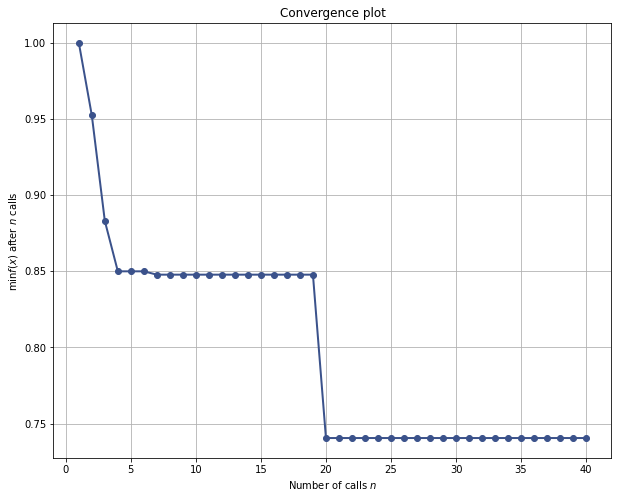

In [116]:
#We get the Optimal Parameters for Catboost from this
CatBoost_Classifier(train,test)

We got the Optimal Parameters above.

---



We will build a CatBoost model using these parameters and train it on our entire train set

In [0]:
@loggg
def CatBoostWithOptimizedParams(train,test):
  from sklearn.metrics import confusion_matrix
  #For Train
  X,y = (train.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))
  features=X.columns
  cate_features_index = np.where(X.dtypes != float)[0]
  cat_features=X.select_dtypes(exclude=[np.float]).columns

  #For Test
  X_test = (test.pipe(start_pipeline).pipe(clean_dataset).pipe(prepare_dataset))

  #The optimal_parameters for Catboost are: {'learning_rate': 0.5545112426934912, 'max_depth': 7, 
  #'colsample_bylevel': 1.0, 'bagging_temperature': 100.0, 'random_strength': 100.0, 
  #'reg_lambda': 1.0} from previous step
  #Lets use these parameters in our model and lets do a K-fold validation

  def make_classifier():
    clf = catboost.CatBoostClassifier(
            n_estimators = 4000,
            task_type = 'CPU',
            random_seed = 31,
            loss_function = 'Logloss',
            learning_rate = 0.5545112426934912,
            max_depth = 7,
            colsample_bylevel = 1.0,
            bagging_temperature = 100.0,
            random_strength = 100.0,
            reg_lambda = 1.0,
            early_stopping_rounds=500,
    )
    return clf
  oof = np.zeros(len(X))
  
  #K-fold CV
  from sklearn.model_selection import KFold
  oof = np.zeros(len(X))
  NFOLDS = 5
  folds = KFold(n_splits=NFOLDS, shuffle=True, random_state=2019)

  training_start_time = time.time()
  for fold, (trn_idx, test_idx) in enumerate(folds.split(X, y)):
    start_time = time.time()
    print(f'Training on fold {fold+1}')
    clf = make_classifier()
    clf.fit(X.loc[trn_idx, features], y.loc[trn_idx], eval_set=(X.loc[test_idx, features], y.loc[test_idx]),
                          use_best_model=True, verbose=500, cat_features=cat_features)    
    oof[test_idx] = clf.predict(X.loc[test_idx, features]).reshape(len(test_idx))
    print('Fold {} finished in {}'.format(fold + 1, str(datetime.timedelta(seconds=time.time() - start_time))))

  print('-' * 30)
  print('Confusion Matrix:\n', confusion_matrix(y,oof))
  print('-' * 30)

  # train model on all data once
  clf = make_classifier()
  clf.fit(X, y, verbose=500, cat_features=cat_features)

  preds = clf.predict(X_test)
  submission = pd.DataFrame({'INCIDENT_ID':test['INCIDENT_ID'],'MULTIPLE_OFFENSE':np.round(preds).astype('int')})
  submission.to_csv('submission_CatBoostWithOptimization.csv',index=False)
  pass

In [118]:
CatBoostWithOptimizedParams(train,test)

Training on fold 1
0:	learn: 0.2430084	test: 0.2462919	best: 0.2462919 (0)	total: 51.7ms	remaining: 3m 26s
500:	learn: 0.0001821	test: 0.0000540	best: 0.0000540 (499)	total: 43.6s	remaining: 5m 4s
1000:	learn: 0.0001630	test: 0.0000498	best: 0.0000498 (1000)	total: 1m 28s	remaining: 4m 25s
1500:	learn: 0.0001270	test: 0.0000394	best: 0.0000394 (1500)	total: 2m 13s	remaining: 3m 42s
2000:	learn: 0.0000900	test: 0.0000327	best: 0.0000327 (2000)	total: 2m 58s	remaining: 2m 58s
2500:	learn: 0.0000820	test: 0.0000305	best: 0.0000305 (2500)	total: 3m 44s	remaining: 2m 14s
3000:	learn: 0.0000759	test: 0.0000287	best: 0.0000287 (3000)	total: 4m 30s	remaining: 1m 30s
3500:	learn: 0.0000713	test: 0.0000274	best: 0.0000274 (3500)	total: 5m 15s	remaining: 45s
3999:	learn: 0.0000670	test: 0.0000261	best: 0.0000261 (3999)	total: 6m 1s	remaining: 0us

bestTest = 2.61490825e-05
bestIteration = 3999

Fold 1 finished in 0:06:02.498296
Training on fold 2
0:	learn: 0.2425168	test: 0.2472815	best: 0.247281

As we can see from the confusion matrix after the K-fold validation, the diagnol elements are 1(close to 0), which means the model was performed pretty good.

**On submission on HackerRank , I got a score of 100 !!**